# Research and evaluation on various tokenization methods

#This notebook is written and reviewed by Ratanakmoni(Ryan) Slot (222146996) & Ahmed Aldhaheri (219256667)

# Cell 1: Introduction and Libraries

#Code by Ahmed

In [101]:
# Print explanation
print("""
This notebook is designed to research and test various tokenization methods for phishing URL detection.
The goal is to evaluate the performance of different tokenizers in breaking down URLs and detecting phishing patterns.
These libraries are essential for the tasks of downloading datasets, processing URLs, tokenizing the data, and evaluating the effectiveness of different tokenization methods.
""")

# Importing necessary libraries
import re  # Regular expressions for tokenization
import tldextract  # Extract domains and subdomains from URLs
import pandas as pd  # Pandas for data manipulation
import matplotlib.pyplot as plt  # Plotting
import requests  # For downloading datasets from the web
import gzip  # For uncompressing gzipped files
import shutil  # For file operations
import csv  # For saving CSV files
from bs4 import BeautifulSoup  # Web scraping to collect legitimate URLs
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.feature_extraction.text import CountVectorizer  # Converting text data into numerical form
from sklearn.linear_model import LogisticRegression  # Machine learning model for classification
from sklearn.metrics import classification_report  # Evaluation metrics for model performance
import os  # For file and directory handling



This notebook is designed to research and test various tokenization methods for phishing URL detection.
The goal is to evaluate the performance of different tokenizers in breaking down URLs and detecting phishing patterns.
These libraries are essential for the tasks of downloading datasets, processing URLs, tokenizing the data, and evaluating the effectiveness of different tokenization methods.



# Cell 2: Download and Uncompress Phishing URLs

#Code by Ahmed

In [102]:
import requests
import gzip
import shutil
import pandas as pd

def download_and_uncompress_phishtank_data():
    # Define the URL for the CSV file
    url = "http://data.phishtank.com/data/online-valid.csv.gz"
    
    # Print a stylish header
    print("═════════════════════════════════════════════════════════════════════")
    print("📥  Downloading Phishing URLs Dataset from PhishTank")
    print("═════════════════════════════════════════════════════════════════════")
    
    # Send a request to download the compressed CSV data
    response = requests.get(url, stream=True)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Save the compressed CSV content to a local file
        with open('phishtank_phishing_urls.csv.gz', 'wb') as file:
            file.write(response.content)
        
        print("✅  Phishing URLs compressed file downloaded successfully.")
        
        # Uncompress the .gz file
        with gzip.open('phishtank_phishing_urls.csv.gz', 'rb') as f_in:
            with open('phishtank_phishing_urls.csv', 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        print("✅  Phishing URLs successfully uncompressed and saved as 'phishtank_phishing_urls.csv'")
    else:
        print(f"❌  Failed to download phishing URLs. Status code: {response.status_code}")
        return

# Run the function to download and uncompress data
download_and_uncompress_phishtank_data()

# Load the CSV into a pandas DataFrame and display the first few rows and the row count
print("\n📝  Previewing the first few rows of the Phishing URLs dataset:")
try:
    phishtank_df = pd.read_csv('phishtank_phishing_urls.csv')
    
    # Get the total number of rows in the dataset
    num_rows = len(phishtank_df)
    
    # Display the number of rows and the first few rows of the dataset
    print("═════════════════════════════════════════════════════════════════════")
    print(f"📊  The dataset contains {num_rows} rows.")
    print("═════════════════════════════════════════════════════════════════════")
    print(phishtank_df.head())
    print("═════════════════════════════════════════════════════════════════════")
except FileNotFoundError:
    print("❌  Error: 'phishtank_phishing_urls.csv' not found. Please ensure the download was successful.")


═════════════════════════════════════════════════════════════════════
📥  Downloading Phishing URLs Dataset from PhishTank
═════════════════════════════════════════════════════════════════════
❌  Failed to download phishing URLs. Status code: 429

📝  Previewing the first few rows of the Phishing URLs dataset:
═════════════════════════════════════════════════════════════════════
📊  The dataset contains 82855 rows.
═════════════════════════════════════════════════════════════════════
   phish_id                                   url  \
0   8727273  https://aserg-105977.weeblysite.com/   
1   8727269    http://docs-learn-trezor.pages.dev   
2   8727268    https://aplwmensduejsa.weebly.com/   
3   8727262                   https://heevri.help   
4   8727256               https://parcelevris.top   

                                    phish_detail_url  \
0  http://www.phishtank.com/phish_detail.php?phis...   
1  http://www.phishtank.com/phish_detail.php?phis...   
2  http://www.phishtank.com

# Cell 3: Scrape Legitimate URLs

#Code by Ahmed

In [103]:
import requests
from bs4 import BeautifulSoup
import csv

def scrape_legitimate_urls():
    # List of websites to scrape legitimate URLs from
    websites = [
        'https://www.bbc.com',  # News website
        'https://www.cnn.com',  # News website
        'https://www.wikipedia.org'  # Educational website
    ]
    
    legitimate_urls = []
    
    # Stylish header for scraping process
    print("═════════════════════════════════════════════════════════════════════")
    print("🌐  Starting the scraping of legitimate URLs from popular websites")
    print("═════════════════════════════════════════════════════════════════════")

    # Loop through each website and scrape the URLs
    for website in websites:
        try:
            print(f"🔗  Scraping URLs from {website} ...")
            response = requests.get(website)
            response.raise_for_status()  # Raise an error for bad responses
            
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Collect all anchor tags with 'href' attributes
            count = 0
            for link in soup.find_all('a', href=True):
                href = link['href']
                # Filter out non-http links and keep only legitimate http/https URLs
                if href.startswith('http'):
                    legitimate_urls.append(href)
                    count += 1

            print(f"✅  Successfully scraped {count} URLs from {website}\n")
        except requests.exceptions.RequestException as e:
            print(f"❌  Failed to scrape {website}. Network error: {str(e)}\n")
        except Exception as e:
            print(f"❌  Failed to scrape {website}. Error: {str(e)}\n")
    
    # Save the legitimate URLs to a CSV file
    if legitimate_urls:
        print("═════════════════════════════════════════════════════════════════════")
        print("💾  Saving the scraped URLs to 'legitimate_urls.csv'")
        try:
            with open('legitimate_urls.csv', 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["URL", "Phishing_Label"])  # Label: 0 for legitimate URLs
                for legitimate_url in legitimate_urls:
                    writer.writerow([legitimate_url, 0])
            
            print(f"✅  Saved {len(legitimate_urls)} legitimate URLs to 'legitimate_urls.csv'")
        except Exception as e:
            print(f"❌  Failed to save the URLs to CSV. Error: {str(e)}")
    else:
        print("❌  No legitimate URLs were scraped, so no file was saved.")
    
    print("═════════════════════════════════════════════════════════════════════")

# Run the function to scrape legitimate URLs
scrape_legitimate_urls()


═════════════════════════════════════════════════════════════════════
🌐  Starting the scraping of legitimate URLs from popular websites
═════════════════════════════════════════════════════════════════════
🔗  Scraping URLs from https://www.bbc.com ...
✅  Successfully scraped 26 URLs from https://www.bbc.com

🔗  Scraping URLs from https://www.cnn.com ...
✅  Successfully scraped 293 URLs from https://www.cnn.com

🔗  Scraping URLs from https://www.wikipedia.org ...
✅  Successfully scraped 8 URLs from https://www.wikipedia.org

═════════════════════════════════════════════════════════════════════
💾  Saving the scraped URLs to 'legitimate_urls.csv'
✅  Saved 327 legitimate URLs to 'legitimate_urls.csv'
═════════════════════════════════════════════════════════════════════


# Cell 4: Combine and Clean Datasets

#Code by Ahmed

In [104]:
import pandas as pd
from sklearn.utils import resample

# Step 1: Combine the datasets
def combine_datasets():
    print("═════════════════════════════════════════════════════════════════════")
    print("🔄  Starting the process of combining Phishing and Legitimate URLs")
    print("═════════════════════════════════════════════════════════════════════")

    try:
        # Load phishing URLs dataset
        phishing_df = pd.read_csv('phishtank_phishing_urls.csv')
        phishing_df['Phishing_Label'] = 1  # Label phishing URLs as 1
        num_phishing = len(phishing_df)
        print(f"🛑  Loaded {num_phishing} phishing URLs from 'phishtank_phishing_urls.csv'")
    except FileNotFoundError:
        print("❌  Error: 'phishtank_phishing_urls.csv' not found.")
        return None

    try:
        # Load legitimate URLs dataset
        legitimate_df = pd.read_csv('legitimate_urls.csv')
        legitimate_df['Phishing_Label'] = 0  # Label legitimate URLs as 0
        num_legitimate = len(legitimate_df)
        print(f"🔗  Loaded {num_legitimate} legitimate URLs from 'legitimate_urls.csv'")
    except FileNotFoundError:
        print("❌  Error: 'legitimate_urls.csv' not found.")
        return None

    # Combine both datasets
    combined_df = pd.concat([phishing_df, legitimate_df], ignore_index=True)
    print(f"✅  Combined dataset contains {len(combined_df)} rows.")
    
    # Save the combined dataset to CSV
    combined_df.to_csv('combined_urls_dataset.csv', index=False)
    
    return combined_df

# Call the combine_datasets function and check if successful
combined_df = combine_datasets()
if combined_df is None:
    raise ValueError("Failed to load and combine datasets. Please check your input files.")

# Step 2: Handle Missing Values (Cleaning the Dataset)
def clean_dataset(df):
    # Drop rows with NaN values in both 'url' and 'URL' columns
    df_cleaned = df.dropna(subset=['url', 'URL'], how='all')  
    
    # Combine 'url' and 'URL' into a single column for cleaning
    df_cleaned['final_url'] = df_cleaned['url'].combine_first(df_cleaned['URL'])
    
    # Filter out invalid URLs that do not start with http/https
    df_cleaned = df_cleaned[df_cleaned['final_url'].str.contains('http|https', regex=True, na=False)]
    
    # Display the number of rows before and after cleaning
    print(f"Rows before cleaning: {len(df)}")
    print(f"Rows after cleaning: {len(df_cleaned)}")
    
    return df_cleaned

# Apply cleaning to the combined dataset
combined_df_cleaned = clean_dataset(combined_df)

# Step 3: Balance the Dataset
def balance_dataset(df):
    phishing_df = df[df['Phishing_Label'] == 1]
    legitimate_df = df[df['Phishing_Label'] == 0]
    
    # Check the sizes of the datasets before balancing
    print(f"Number of phishing URLs before balancing: {len(phishing_df)}")
    print(f"Number of legitimate URLs before balancing: {len(legitimate_df)}")
    
    if len(legitimate_df) == 0:
        raise ValueError("No legitimate URLs found after cleaning.")
    
    # Oversample legitimate URLs to match the number of phishing URLs
    legitimate_oversampled = resample(legitimate_df, 
                                      replace=True,  # Allow resampling with replacement
                                      n_samples=len(phishing_df),  # Match phishing count
                                      random_state=42)
    
    # Check the sizes after oversampling
    print(f"Number of legitimate URLs after oversampling: {len(legitimate_oversampled)}")
    
    # Combine the oversampled legitimate URLs with the phishing URLs
    balanced_df = pd.concat([phishing_df, legitimate_oversampled])
    
    # Shuffle the combined dataset to mix phishing and legitimate URLs
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Display the final class distribution
    print("Final class distribution:")
    print(balanced_df['Phishing_Label'].value_counts())
    
    return balanced_df

# Apply balancing to the cleaned dataset
balanced_df = balance_dataset(combined_df_cleaned)

# Save the balanced dataset to CSV
balanced_df.to_csv('balanced_urls_dataset.csv', index=False)
print("✅  Balanced dataset saved as 'balanced_urls_dataset.csv'")


═════════════════════════════════════════════════════════════════════
🔄  Starting the process of combining Phishing and Legitimate URLs
═════════════════════════════════════════════════════════════════════
🛑  Loaded 82855 phishing URLs from 'phishtank_phishing_urls.csv'
🔗  Loaded 327 legitimate URLs from 'legitimate_urls.csv'
✅  Combined dataset contains 83182 rows.
Rows before cleaning: 83182
Rows after cleaning: 83182
Number of phishing URLs before balancing: 82855
Number of legitimate URLs before balancing: 327
Number of legitimate URLs after oversampling: 82855
Final class distribution:
0    82855
1    82855
Name: Phishing_Label, dtype: int64
✅  Balanced dataset saved as 'balanced_urls_dataset.csv'


# Regex-Based Tokenization

#Code by Ahmed

In [105]:
import re
import pandas as pd

def regex_tokenization():
    print("═════════════════════════════════════════════════════════════════════")
    print("🔍  Regex-Based Tokenization on URLs")
    print("═════════════════════════════════════════════════════════════════════")
    
    # Load the combined dataset
    try:
        combined_df = pd.read_csv('combined_urls_dataset.csv', dtype={'url': str}, low_memory=False)
        num_rows = len(combined_df)
        print(f"✅  Loaded {num_rows} URLs from 'combined_urls_dataset.csv'")
    except FileNotFoundError:
        print("❌  Error: 'combined_urls_dataset.csv' not found.")
        return
    except pd.errors.EmptyDataError:
        print("❌  Error: The CSV file is empty or malformed.")
        return

    # Check for NaN values in the 'url' column
    nan_count = combined_df['url'].isna().sum()
    print(f"⚠️  Found {nan_count} NaN or invalid URLs. Removing them...")
    
    # Remove rows with NaN in the 'url' column
    combined_df = combined_df.dropna(subset=['url'])
    
    # Regex-based tokenization
    def regex_tokenizer(url):
        if isinstance(url, str):
            tokens = re.split(r'[/:.?=&-]', url)
            return [token for token in tokens if token]  # Remove empty tokens
        else:
            return []  # Return an empty list if the value is not a string
    
    # Apply regex tokenization to the valid URLs
    combined_df['regex_tokens'] = combined_df['url'].apply(regex_tokenizer)
    
    # Print a sample of tokenized data
    print("🔍  Sample of Tokenized Data (Regex-Based):")
    print(combined_df[['url', 'regex_tokens']].head(10))
    
    # Save the tokenized dataset
    combined_df.to_csv('regex_tokenized_urls_dataset.csv', index=False)
    print("💾  Regex-Tokenized dataset saved as 'regex_tokenized_urls_dataset.csv'")

# Run the regex-based tokenization
regex_tokenization()


═════════════════════════════════════════════════════════════════════
🔍  Regex-Based Tokenization on URLs
═════════════════════════════════════════════════════════════════════
✅  Loaded 83182 URLs from 'combined_urls_dataset.csv'
⚠️  Found 327 NaN or invalid URLs. Removing them...
🔍  Sample of Tokenized Data (Regex-Based):
                                                 url  \
0               https://aserg-105977.weeblysite.com/   
1                 http://docs-learn-trezor.pages.dev   
2                 https://aplwmensduejsa.weebly.com/   
3                                https://heevri.help   
4                            https://parcelevris.top   
5       https://btinternet98715.activehosted.com/f/1   
6  https://us22.list-manage.com/survey?u=9060fb04...   
7  https://us22.list-manage.com/survey?u=94c6d169...   
8  https://us22.list-manage.com/survey?u=97e288ae...   
9  https://us22.list-manage.com/survey?u=97e288ae...   

                                        regex_tokens  
0  

# TLD and Subdomain Tokenization

#Code by Ryan

In [106]:
import tldextract
import pandas as pd

def tld_subdomain_tokenization():
    print("═════════════════════════════════════════════════════════════════════")
    print("🔍  TLD and Subdomain Tokenization on URLs")
    print("═════════════════════════════════════════════════════════════════════")
    
    # Load the combined dataset
    try:
        combined_df = pd.read_csv('combined_urls_dataset.csv', dtype={'url': str}, low_memory=False)
        num_rows = len(combined_df)
        print(f"✅  Loaded {num_rows} URLs from 'combined_urls_dataset.csv'")
    except FileNotFoundError:
        print("❌  Error: 'combined_urls_dataset.csv' not found.")
        return
    
    # TLD extraction with NaN handling
    def extract_tld(url):
        if isinstance(url, str):
            extracted = tldextract.extract(url)
            return pd.Series([extracted.subdomain, extracted.domain, extracted.suffix])
        else:
            return pd.Series([None, None, None])
    
    # Apply TLD and subdomain extraction to the 'url' column
    combined_df[['subdomain', 'domain', 'tld']] = combined_df['url'].apply(extract_tld)
    
    # Print a sample of extracted data
    print("🔍  Sample of Extracted TLD and Subdomain Data:")
    print(combined_df[['url', 'subdomain', 'domain', 'tld']].head(10))
    
    # Save the tokenized dataset
    combined_df.to_csv('tld_subdomain_tokenized_urls_dataset.csv', index=False)
    print("💾  TLD and Subdomain Tokenized dataset saved as 'tld_subdomain_tokenized_urls_dataset.csv'")

# Run the TLD and subdomain tokenization
tld_subdomain_tokenization()


═════════════════════════════════════════════════════════════════════
🔍  TLD and Subdomain Tokenization on URLs
═════════════════════════════════════════════════════════════════════
✅  Loaded 83182 URLs from 'combined_urls_dataset.csv'
🔍  Sample of Extracted TLD and Subdomain Data:
                                                 url          subdomain  \
0               https://aserg-105977.weeblysite.com/       aserg-105977   
1                 http://docs-learn-trezor.pages.dev  docs-learn-trezor   
2                 https://aplwmensduejsa.weebly.com/     aplwmensduejsa   
3                                https://heevri.help                      
4                            https://parcelevris.top                      
5       https://btinternet98715.activehosted.com/f/1    btinternet98715   
6  https://us22.list-manage.com/survey?u=9060fb04...               us22   
7  https://us22.list-manage.com/survey?u=94c6d169...               us22   
8  https://us22.list-manage.com/survey?u=9

# Custom String Matching Tokenization

#Code by Ryan

In [107]:
import pandas as pd
import re
from urllib.parse import urlparse, unquote
import logging

# Setup logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def custom_string_matching_tokenization():
    logging.info("Starting Custom String Matching Tokenization on URLs")
    
    # Load the combined dataset
    try:
        combined_df = pd.read_csv('combined_urls_dataset.csv', dtype={'url': str}, low_memory=False)
        num_rows = len(combined_df)
        logging.info(f"✅  Loaded {num_rows} URLs from 'combined_urls_dataset.csv'")
    except FileNotFoundError:
        logging.error("❌  Error: 'combined_urls_dataset.csv' not found.")
        return
    except Exception as e:
        logging.error(f"❌  Unexpected error: {e}")
        return

    # Expanded list of known brand names commonly targeted by phishers
    known_brands = [
        'paypal', 'google', 'facebook', 'apple', 'amazon', 'microsoft',
        'netflix', 'bankofamerica', 'linkedin', 'ebay', 'instagram', 'twitter', 
        'yahoo', 'dropbox', 'chase', 'wellsfargo', 'spotify', 'uber', 'airbnb',
        'americanexpress', 'visa', 'mastercard', 'tiktok', 'whatsapp', 'snapchat',
        'citibank', 'hsbc', 'barclays', 'alibaba', 'reddit', 'pinterest', 'adobe', 
        'icloud', 'office365', 'gmail', 'outlook', 'hotmail', 'samsung', 'sony',
        'disney', 'hulu', 'zoom', 'github', 'at&t', 'verizon', 'xfinity', 'myspace',
        'bitbucket', 'slack', 'zendesk', 't-mobile', 'dell', 'hp', 'lenovo', 'nike',
        # ... (continue adding more brands as needed)
    ]
    
    # Create a single regex pattern from the brand list for better performance
    brand_pattern = re.compile('|'.join([re.escape(brand) for brand in known_brands]), re.IGNORECASE)
    
    # Function to normalize URLs (remove query parameters, fragments)
    def normalize_url(url):
        if isinstance(url, str):
            try:
                parsed_url = urlparse(url)
                normalized_url = f"{parsed_url.scheme}://{parsed_url.netloc}{parsed_url.path}"
                return normalized_url
            except Exception as e:
                logging.warning(f"Error normalizing URL: {url}, Error: {e}")
                return url  # Return original if parsing fails
        return None

    # Function to decode URLs (handle encoded characters)
    def decode_url(url):
        if isinstance(url, str):
            try:
                return unquote(url)
            except Exception as e:
                logging.warning(f"Error decoding URL: {url}, Error: {e}")
                return url  # Return original if decoding fails
        return None

    # Normalize and decode URLs before detection, skipping NaN values
    combined_df['url'] = combined_df['url'].apply(lambda x: decode_url(normalize_url(x)))
    
    # Custom string matching using the compiled regex pattern
    def brand_name_detector(url):
        if isinstance(url, str):
            matches = brand_pattern.findall(url)
            return list(set(matches)) if matches else None  # Remove duplicates
        return None
    
    # Apply brand name detection
    combined_df['detected_brands'] = combined_df['url'].apply(brand_name_detector)
    
    # Filter for rows where brands were detected
    brands_detected_df = combined_df[combined_df['detected_brands'].notnull()]
    
    # Print a sample of detected brands
    logging.info("🔍  Sample of Detected Brands Data (Where Brands Were Found):")
    logging.info(brands_detected_df[['url', 'detected_brands']].head(10).to_string(index=False))
    
    # Save the filtered dataset where brands were detected
    brands_detected_df.to_csv('brands_detected_urls_dataset.csv', index=False)
    logging.info("💾  Detected Brands dataset saved as 'brands_detected_urls_dataset.csv'")
    
    # Save the full tokenized dataset
    combined_df.to_csv('custom_string_matching_tokenized_urls_dataset.csv', index=False)
    logging.info("💾  Full Custom String Matching Tokenized dataset saved as 'custom_string_matching_tokenized_urls_dataset.csv'")

# Run the custom string matching tokenization
custom_string_matching_tokenization()


2024-08-23 18:03:51,640 - INFO - Starting Custom String Matching Tokenization on URLs
2024-08-23 18:03:51,883 - INFO - ✅  Loaded 83182 URLs from 'combined_urls_dataset.csv'
2024-08-23 18:03:54,896 - INFO - 🔍  Sample of Detected Brands Data (Where Brands Were Found):
2024-08-23 18:03:54,900 - INFO -                                                                                                  url    detected_brands
https://www.dropbox.com/bl2/AAAyz8iMegZK1kgRdC8B9pQlHbTIco8UZDC32Iypf5g_9A/swright966@btinternet.com          [dropbox]
                                       https://www.dropbox.com/l/AAA3ORqKB52Cm1ApqzxBhTvLzPJpGEy4SDI          [dropbox]
                               https://www.dropbox.com/l/AADMvvP6HzkDd5QFQPKcs5vUwVE8SmTeKvQ/privacy          [dropbox]
                   https://www.dropbox.com/scl/fi/2379srkv9cbtolge3uho1/Welcome-To-BT-Dropbox.papert [Dropbox, dropbox]
                                   https://www.dropbox.com/l/scl/AABx2UFBc-YJgYpshjK5olTq06aRUGcV6JM

# Comparison

#Code by Ryan

In [108]:
import pandas as pd

def tld_token_volume_fix():
    print("═════════════════════════════════════════════════════════════════════")
    print("🔍  Fixing TLD & Subdomain Tokenization Calculation")
    print("═════════════════════════════════════════════════════════════════════")
    
    # Load the TLD & Subdomain tokenized dataset
    try:
        tld_df = pd.read_csv('debugged_tld_subdomain_tokenized_urls_dataset.csv', dtype={'url': str}, low_memory=False)
        num_rows = len(tld_df)
        print(f"✅  Loaded {num_rows} URLs from 'debugged_tld_subdomain_tokenized_urls_dataset.csv'")
    except FileNotFoundError:
        print("❌  Error: 'debugged_tld_subdomain_tokenized_urls_dataset.csv' not found.")
        return

    # Calculate token counts for each URL
    def count_tld_tokens(row):
        tokens = 0
        if pd.notna(row['subdomain']) and row['subdomain'].strip():
            tokens += len(row['subdomain'].split('.'))  # Split subdomain by '.'
        if pd.notna(row['domain']) and row['domain'].strip():
            tokens += 1  # Domain is one token
        if pd.notna(row['tld']) and row['tld'].strip():
            tokens += 1  # TLD is one token
        return tokens
    
    tld_df['token_count'] = tld_df.apply(count_tld_tokens, axis=1)
    
    # Calculate total and average tokens
    total_tokens = tld_df['token_count'].sum()
    avg_tokens_per_url = tld_df['token_count'].mean()
    
    print(f"Total Tokens (TLD & Subdomain): {total_tokens}, Average Tokens per URL: {avg_tokens_per_url:.2f}")
    
    # Save the updated dataset with token count
    tld_df.to_csv('updated_tld_subdomain_tokenized_urls_dataset.csv', index=False)
    print("💾  Updated TLD & Subdomain Tokenized dataset saved as 'updated_tld_subdomain_tokenized_urls_dataset.csv'")

# Run the fix for TLD & Subdomain tokenization
tld_token_volume_fix()


═════════════════════════════════════════════════════════════════════
🔍  Fixing TLD & Subdomain Tokenization Calculation
═════════════════════════════════════════════════════════════════════
✅  Loaded 83186 URLs from 'debugged_tld_subdomain_tokenized_urls_dataset.csv'
Total Tokens (TLD & Subdomain): 232680, Average Tokens per URL: 2.80
💾  Updated TLD & Subdomain Tokenized dataset saved as 'updated_tld_subdomain_tokenized_urls_dataset.csv'


In [109]:
import time
import pandas as pd

# Load datasets for each tokenization method
regex_df = pd.read_csv('debugged_regex_tokenized_urls_dataset.csv')
tld_df = pd.read_csv('updated_tld_subdomain_tokenized_urls_dataset.csv')  # Make sure this points to the updated dataset
custom_df = pd.read_csv('custom_string_matching_tokenized_urls_dataset.csv')

# Step 1: Measure Execution Time for each method
def measure_execution_time(func):
    start_time = time.time()
    func()
    end_time = time.time()
    return end_time - start_time

# Placeholder functions for the tokenization methods (replace with actual implementations)
def regex_tokenization():
    pd.read_csv('debugged_regex_tokenized_urls_dataset.csv')

def tld_tokenization():
    pd.read_csv('updated_tld_subdomain_tokenized_urls_dataset.csv')

def custom_string_matching():
    pd.read_csv('custom_string_matching_tokenized_urls_dataset.csv')

# Measure execution times
regex_time = measure_execution_time(regex_tokenization)
tld_time = measure_execution_time(tld_tokenization)
custom_time = measure_execution_time(custom_string_matching)

print(f"Execution Time for Regex-Based Tokenization: {regex_time:.4f} seconds")
print(f"Execution Time for TLD & Subdomain Tokenization: {tld_time:.4f} seconds")
print(f"Execution Time for Custom String Matching Tokenization: {custom_time:.4f} seconds")

# Step 2: Tokenization Volume Comparison
def calculate_token_volume(df, token_column):
    if isinstance(token_column, list):  # Special handling for TLD & Subdomain
        total_tokens = df[token_column].apply(lambda row: sum([len(str(x).split()) if pd.notna(x) else 0 for x in row]), axis=1).sum()
        avg_tokens_per_url = df[token_column].apply(lambda row: sum([len(str(x).split()) if pd.notna(x) else 0 for x in row]), axis=1).mean()
    else:  # For other tokenization methods
        total_tokens = df[token_column].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0).sum()
        avg_tokens_per_url = df[token_column].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0).mean()
    return total_tokens, avg_tokens_per_url

# Calculate token volumes for each method
regex_total_tokens, regex_avg_tokens = calculate_token_volume(regex_df, 'regex_tokens')
tld_total_tokens, tld_avg_tokens = calculate_token_volume(tld_df, ['subdomain', 'domain', 'tld'])
custom_total_tokens, custom_avg_tokens = calculate_token_volume(custom_df, 'detected_brands')

print(f"Total Tokens (Regex): {regex_total_tokens}, Average Tokens per URL: {regex_avg_tokens:.2f}")
print(f"Total Tokens (TLD & Subdomain): {tld_total_tokens}, Average Tokens per URL: {tld_avg_tokens:.2f}")
print(f"Total Tokens (Custom String Matching): {custom_total_tokens}, Average Tokens per URL: {custom_avg_tokens:.2f}")


/var/folders/b4/8n_bs6jd1bv4ww25k9s6r3xc0000gn/T/ipykernel_6037/809808484.py:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  tld_df = pd.read_csv('updated_tld_subdomain_tokenized_urls_dataset.csv')  # Make sure this points to the updated dataset
/var/folders/b4/8n_bs6jd1bv4ww25k9s6r3xc0000gn/T/ipykernel_6037/809808484.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  custom_df = pd.read_csv('custom_string_matching_tokenized_urls_dataset.csv')
/var/folders/b4/8n_bs6jd1bv4ww25k9s6r3xc0000gn/T/ipykernel_6037/809808484.py:21: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('updated_tld_subdomain_tokenized_urls_dataset.csv')
/var/folders/b4/8n_bs6jd1bv4ww25k9s6r3xc0000gn/T/ipykernel_6037/809808484.py:24: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_

Execution Time for Regex-Based Tokenization: 0.4337 seconds
Execution Time for TLD & Subdomain Tokenization: 0.2846 seconds
Execution Time for Custom String Matching Tokenization: 0.2886 seconds
Total Tokens (Regex): 554009, Average Tokens per URL: 6.69
Total Tokens (TLD & Subdomain): 224977, Average Tokens per URL: 2.70
Total Tokens (Custom String Matching): 14823, Average Tokens per URL: 0.18


/var/folders/b4/8n_bs6jd1bv4ww25k9s6r3xc0000gn/T/ipykernel_6037/4132423570.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  tld_df = pd.read_csv('updated_tld_subdomain_tokenized_urls_dataset.csv')
/var/folders/b4/8n_bs6jd1bv4ww25k9s6r3xc0000gn/T/ipykernel_6037/4132423570.py:8: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  custom_df = pd.read_csv('custom_string_matching_tokenized_urls_dataset.csv')


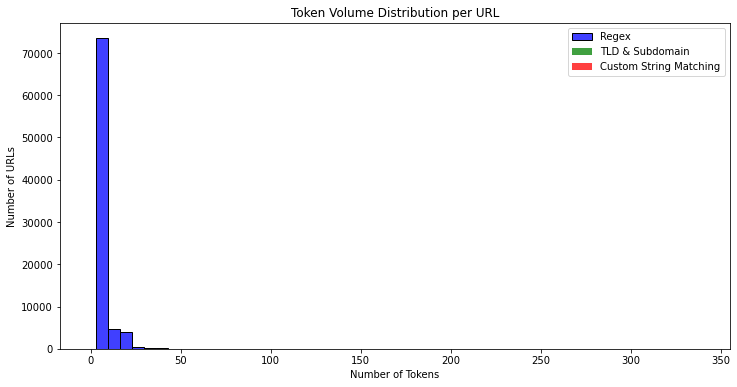

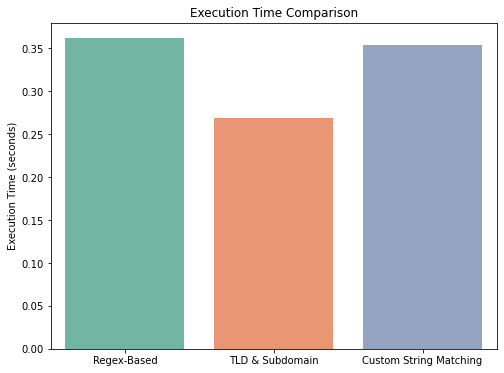

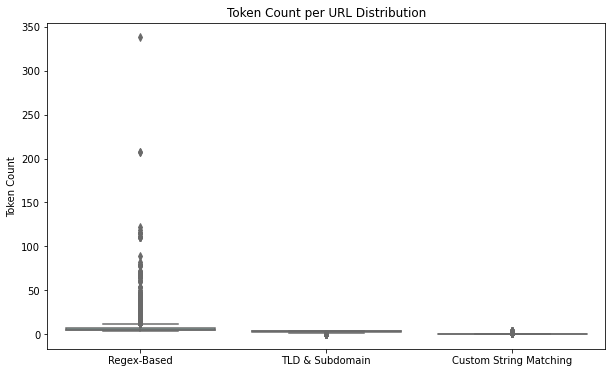

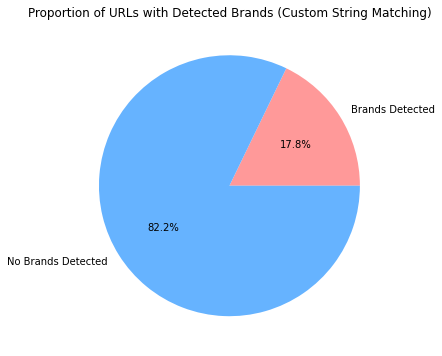

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load datasets
regex_df = pd.read_csv('debugged_regex_tokenized_urls_dataset.csv')
tld_df = pd.read_csv('updated_tld_subdomain_tokenized_urls_dataset.csv')
custom_df = pd.read_csv('custom_string_matching_tokenized_urls_dataset.csv')

# 1. Histogram - Token Volume Distribution
plt.figure(figsize=(12, 6))
sns.histplot(regex_df['regex_tokens'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0), color='blue', label='Regex', kde=False, bins=50)
sns.histplot(tld_df[['subdomain', 'domain', 'tld']].apply(lambda x: len([val for val in x if pd.notna(val)]), axis=1), color='green', label='TLD & Subdomain', kde=False, bins=50)
sns.histplot(custom_df['detected_brands'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0), color='red', label='Custom String Matching', kde=False, bins=50)
plt.title("Token Volume Distribution per URL")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of URLs")
plt.legend()
plt.show()

# 2. Bar Chart - Execution Time Comparison
execution_times = [0.3620, 0.2686, 0.3538]  # Replace with actual values from your run
methods = ['Regex-Based', 'TLD & Subdomain', 'Custom String Matching']

plt.figure(figsize=(8, 6))
sns.barplot(x=methods, y=execution_times, palette='Set2')
plt.title("Execution Time Comparison")
plt.ylabel("Execution Time (seconds)")
plt.show()

# 3. Box Plot - Token Count per URL Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=[regex_df['regex_tokens'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0),
                  tld_df[['subdomain', 'domain', 'tld']].apply(lambda x: len([val for val in x if pd.notna(val)]), axis=1),
                  custom_df['detected_brands'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)],
            palette='Set3')
plt.xticks([0, 1, 2], ['Regex-Based', 'TLD & Subdomain', 'Custom String Matching'])
plt.title("Token Count per URL Distribution")
plt.ylabel("Token Count")
plt.show()

# 4. Pie Chart - Proportion of URLs with Detected Brands (Custom String Matching)
brands_detected = custom_df['detected_brands'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0).sum()
total_urls = len(custom_df)
no_brands_detected = total_urls - brands_detected

plt.figure(figsize=(6, 6))
plt.pie([brands_detected, no_brands_detected], labels=['Brands Detected', 'No Brands Detected'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title("Proportion of URLs with Detected Brands (Custom String Matching)")
plt.show()
